<a href="https://colab.research.google.com/github/sprerak48/Autonomous-tagging-using-Deep-Learning/blob/Prerak/AT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('Our pythn shared notebook we can code here')

Our pythn shared notebook we can code here


In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d stackoverflow/stacksample

 99% 1.13G/1.15G [00:13<00:00, 98.4MB/s]
100% 1.15G/1.15G [00:13<00:00, 88.2MB/s]


In [5]:
!unzip stacksample


Archive:  stacksample.zip
  inflating: Answers.csv             
  inflating: Questions.csv           
  inflating: Tags.csv                


In [0]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import math

questions = pd.read_csv("Questions.csv", encoding='latin1')
answers = pd.read_csv("Answers.csv", encoding='latin1')
tags = pd.read_csv("Tags.csv", encoding='latin1')

In [0]:
ans_per_question = collections.Counter(answers['ParentId'])
answerid,noAnswers= zip(*ans_per_question.most_common())
text = "Avegrage number of answers per question ",np.mean(noAnswers)

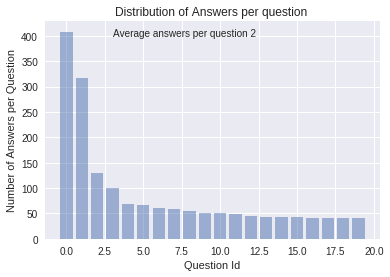

In [11]:
N=20
plt.bar(range(N), noAnswers[:N], align='center', alpha=0.5)
#plt.xticks(y_pos, objects)

plt.ylabel('Number of Answers per Question')
plt.xlabel('Question Id')
plt.title('Distribution of Answers per question ')
plt.text(3,400,"Average answers per question "+str(math.ceil((np.mean(noAnswers)))))

plt.show()

In [12]:
print("Top 2 Questions with maximum number of answers \n")
qid = answerid[:2] 

for b,id in zip(questions['Body'],questions['Id']):
    if id in qid:
        #print(id)
        print(b)
        print("................")

Top 2 Questions with maximum number of answers 

<p>This is a <a href="http://stackoverflow.com/questions/tagged/polls">poll</a> asking the Stackoverflow community what <strong>non-programming</strong> books they would recommend to fellow programmers.</p>

<h3>Please read the following before posting:</h3>

<ul>
<li><p>Please post only <em>ONE BOOK PER ANSWER</em>.</p></li>
<li><p>Please <em>search for your recommendation on this page before posting</em> (there are over NINE PAGES so it is advisable to check them all). Many books have already been suggested and we want to avoid duplicates. If you find your recommendation is already present, vote it up or add some commentary.</p></li>
<li><p><strong>Please elaborate</strong> <em>on <strong>why</strong> you think a given book is worth reading</em> <strong><em>from a programmer's perspective.</em></strong></p></li>
</ul>

<p>Note: <a href="http://stackoverflow.com/questions/31274/best-non-development-book-for-software-developers">this art

In [0]:
def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(9,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


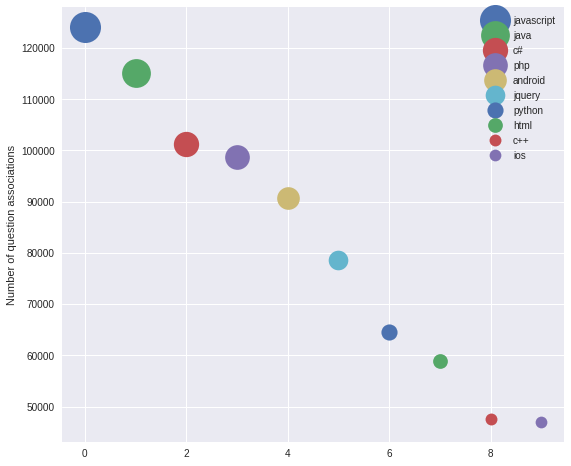

In [14]:
tagCount =  collections.Counter(list(tags['Tag'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

In [15]:
topQuestions =list(zip(questions["Id"],questions["Score"],questions["Title"]))
topQuestions.sort(key=lambda x: x[1],reverse=True)
for id,s,t in topQuestions[:20]:
    #print("Question id:",id)
    print("Score :",s)
    print("Question Title\t:",t,'\n') 

Score : 5190
Question Title	: How to undo 'git add' before commit? 

Score : 3613
Question Title	: Is Java "pass-by-reference" or "pass-by-value"? 

Score : 2537
Question Title	: Regular expression to match line that doesn't contain a word? 

Score : 2399
Question Title	: Make an existing Git branch track a remote branch? 

Score : 2363
Question Title	: Why does Google prepend while(1); to their JSON responses? 

Score : 1760
Question Title	: How to check if a string contains a specific word in PHP? 

Score : 1759
Question Title	: How do I empty an array in JavaScript? 

Score : 1716
Question Title	: How to find all files containing specific text on Linux? 

Score : 1620
Question Title	: Loop through an array in JavaScript 

Score : 1614
Question Title	: How do you disable browser Autocomplete on web form field / input tag? 

Score : 1613
Question Title	: How do I give text or an image a transparent background using CSS? 

Score : 1567
Question Title	: How can I determine the URL that 